In [1]:
"""
    IMPORTING LIBS
"""
import dgl

import numpy as np
import matplotlib.pyplot as plt
import os
import socket
import time
import random
import glob
import argparse, json
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.utils.data import DataLoader

from tensorboardX import SummaryWriter
from tqdm import tqdm

"""
    IMPORTING CUSTOM MODULES/METHODS
"""
from nets.molecules_graph_regression.load_net import gnn_model 
from data.data import LoadData 

Using backend: pytorch


In [2]:
class DotDict(dict):
    def __init__(self, **kwds):
        self.update(kwds)
        self.__dict__ = self

"""
    GPU Setup
"""
def gpu_setup(use_gpu, gpu_id):
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)  

    if torch.cuda.is_available() and use_gpu:
        print('cuda available with GPU:',torch.cuda.get_device_name(0))
        device = torch.device("cuda")
    else:
        print('cuda not available')
        device = torch.device("cpu")
    return device


"""
    VIEWING MODEL CONFIG AND PARAMS
"""
def view_model_param(MODEL_NAME, net_params):
    model = gnn_model(MODEL_NAME, net_params)
    total_param = 0
    print("MODEL DETAILS:\n")
    #print(model)
    for param in model.parameters():
        # print(param.data.size())
        total_param += np.prod(list(param.data.size()))
    print('MODEL/Total parameters:', MODEL_NAME, total_param)
    return total_param

"""
    TRAINING CODE
"""

def train_val_pipeline(MODEL_NAME, dataset, params, net_params, dirs):

    t0 = time.time()
    per_epoch_time = []
        
    DATASET_NAME = dataset.name
    
    if net_params['lap_pos_enc']:
        st = time.time()
        print("[!] Adding Laplacian positional encoding.")
        dataset._add_laplacian_positional_encodings(net_params['pos_enc_dim'])
        print('Time LapPE:',time.time()-st)
        
    if net_params['wl_pos_enc']:
        st = time.time()
        print("[!] Adding WL positional encoding.")
        dataset._add_wl_positional_encodings()
        print('Time WL PE:',time.time()-st)
    
    if net_params['full_graph']:
        st = time.time()
        print("[!] Converting the given graphs to full graphs..")
        dataset._make_full_graph()
        print('Time taken to convert to full graphs:',time.time()-st)    
        
    trainset, valset, testset = dataset.train, dataset.val, dataset.test
        
    root_log_dir, root_ckpt_dir, write_file_name, write_config_file = dirs
    device = net_params['device']
    
    # Write the network and optimization hyper-parameters in folder config/
    with open(write_config_file + '.txt', 'w') as f:
        f.write("""Dataset: {},\nModel: {}\n\nparams={}\n\nnet_params={}\n\n\nTotal Parameters: {}\n\n"""                .format(DATASET_NAME, MODEL_NAME, params, net_params, net_params['total_param']))
        
    log_dir = os.path.join(root_log_dir, "RUN_" + str(0))
    writer = SummaryWriter(log_dir=log_dir)

    # setting seeds
    random.seed(params['seed'])
    np.random.seed(params['seed'])
    torch.manual_seed(params['seed'])
    if device.type == 'cuda':
        torch.cuda.manual_seed(params['seed'])
    
    print("Training Graphs: ", len(trainset))
    print("Validation Graphs: ", len(valset))
    print("Test Graphs: ", len(testset))

    model = gnn_model(MODEL_NAME, net_params)
    model = model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=params['init_lr'], weight_decay=params['weight_decay'])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                     factor=params['lr_reduce_factor'],
                                                     patience=params['lr_schedule_patience'],
                                                     verbose=True)
    
    epoch_train_losses, epoch_val_losses = [], []
    epoch_train_MAEs, epoch_val_MAEs = [], [] 
    scores = []

    # import train and evaluate functions
    from train.EA_train_molecules_graph_regression import train_epoch, evaluate_network

    train_loader = DataLoader(trainset, batch_size=params['batch_size'], shuffle=True, collate_fn=dataset.collate)
    val_loader = DataLoader(valset, batch_size=params['batch_size'], shuffle=False, collate_fn=dataset.collate)
    test_loader = DataLoader(testset, batch_size=params['batch_size'], shuffle=False, collate_fn=dataset.collate)
    
    # At any point you can hit Ctrl + C to break out of training early.
    try:
        with tqdm(range(params['epochs'])) as t:
            for epoch in t:

                t.set_description('Epoch %d' % epoch)

                start = time.time()

                epoch_train_loss, epoch_train_mae, optimizer, scores_epoch = train_epoch(model, optimizer, device, train_loader, epoch)
                    
                epoch_val_loss, epoch_val_mae = evaluate_network(model, device, val_loader, epoch)
                _, epoch_test_mae = evaluate_network(model, device, test_loader, epoch)
                
                if epoch%10==0:
                    scores.append(scores_epoch)
                
                epoch_train_losses.append(epoch_train_loss)
                epoch_val_losses.append(epoch_val_loss)
                epoch_train_MAEs.append(epoch_train_mae)
                epoch_val_MAEs.append(epoch_val_mae)

                writer.add_scalar('train/_loss', epoch_train_loss, epoch)
                writer.add_scalar('val/_loss', epoch_val_loss, epoch)
                writer.add_scalar('train/_mae', epoch_train_mae, epoch)
                writer.add_scalar('val/_mae', epoch_val_mae, epoch)
                writer.add_scalar('test/_mae', epoch_test_mae, epoch)
                writer.add_scalar('learning_rate', optimizer.param_groups[0]['lr'], epoch)

                        
                t.set_postfix(time=time.time()-start, lr=optimizer.param_groups[0]['lr'],
                              train_loss=epoch_train_loss, val_loss=epoch_val_loss,
                              train_MAE=epoch_train_mae, val_MAE=epoch_val_mae,
                              test_MAE=epoch_test_mae)


                per_epoch_time.append(time.time()-start)

                # Saving checkpoint
                ckpt_dir = os.path.join(root_ckpt_dir, "RUN_")
                if not os.path.exists(ckpt_dir):
                    os.makedirs(ckpt_dir)
                torch.save(model.state_dict(), '{}.pkl'.format(ckpt_dir + "/epoch_" + str(epoch)))

                files = glob.glob(ckpt_dir + '/*.pkl')
                for file in files:
                    epoch_nb = file.split('_')[-1]
                    epoch_nb = int(epoch_nb.split('.')[0])
                    if epoch_nb < epoch-1:
                        os.remove(file)

                scheduler.step(epoch_val_loss)

                if optimizer.param_groups[0]['lr'] < params['min_lr']:
                    print("\n!! LR EQUAL TO MIN LR SET.")
                    break
                
                # Stop training after params['max_time'] hours
                if time.time()-t0 > params['max_time']*3600:
                    print('-' * 89)
                    print("Max_time for training elapsed {:.2f} hours, so stopping".format(params['max_time']))
                    break
                
    except KeyboardInterrupt:
        print('-' * 89)
        print('Exiting from training early because of KeyboardInterrupt')
    
    _, test_mae = evaluate_network(model, device, test_loader, epoch)
    _, train_mae = evaluate_network(model, device, train_loader, epoch)
    print("Test MAE: {:.4f}".format(test_mae))
    print("Train MAE: {:.4f}".format(train_mae))
    print("Convergence Time (Epochs): {:.4f}".format(epoch))
    print("TOTAL TIME TAKEN: {:.4f}s".format(time.time()-t0))
    print("AVG TIME PER EPOCH: {:.4f}s".format(np.mean(per_epoch_time)))
    
    fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(25,15))
    for i in range(2):
        for j in range(5):
            axs[i,j].hist(scores[j + i*5])
            axs[i,j].set_title('Epoch '+str((j + i*5)*10))
    writer.close()

    """
        Write the results in out_dir/results folder
    """
    with open(write_file_name + '.txt', 'w') as f:
        f.write("""Dataset: {},\nModel: {}\n\nparams={}\n\nnet_params={}\n\n{}\n\nTotal Parameters: {}\n\n
    FINAL RESULTS\nTEST MAE: {:.4f}\nTRAIN MAE: {:.4f}\n\n
    Convergence Time (Epochs): {:.4f}\nTotal Time Taken: {:.4f} hrs\nAverage Time Per Epoch: {:.4f} s\n\n\n"""\
          .format(DATASET_NAME, MODEL_NAME, params, net_params, model, net_params['total_param'],
                  test_mae, train_mae, epoch, (time.time()-t0)/3600, np.mean(per_epoch_time)))

In [3]:
"""
    USER CONTROLS
"""

config = open('configs/molecules_GraphTransformer_LapPE_ZINC_500k_sparse_graph_BN.json')
config = json.load(config)

In [4]:
def main():    
    
    device = gpu_setup(True, 0)
    
    # model, dataset, out_dir
    MODEL_NAME = config['model']
    DATASET_NAME = config['dataset']
    dataset = LoadData(DATASET_NAME)
    out_dir = config['out_dir']
    
    # parameters
    params = config['params']
    
    # modif
    
    params['epochs'] = 100
    
    # end modif
    
    # network parameters
    net_params = config['net_params']
    net_params['device'] = device
    net_params['gpu_id'] = config['gpu']['id']
    net_params['batch_size'] = params['batch_size']
    
    # ZINC
    net_params['num_atom_type'] = dataset.num_atom_type
    net_params['num_bond_type'] = dataset.num_bond_type
    
    root_log_dir = out_dir + 'logs/' + MODEL_NAME + "_EA_" + DATASET_NAME + "_GPU" + str(config['gpu']['id']) + "_" + time.strftime('%Hh%Mm%Ss_on_%b_%d_%Y')
    root_ckpt_dir = out_dir + 'checkpoints/' + MODEL_NAME + "_EA_" + DATASET_NAME + "_GPU" + str(config['gpu']['id']) + "_" + time.strftime('%Hh%Mm%Ss_on_%b_%d_%Y')
    write_file_name = out_dir + 'results/result_' + MODEL_NAME + "_EA_" + DATASET_NAME + "_GPU" + str(config['gpu']['id']) + "_" + time.strftime('%Hh%Mm%Ss_on_%b_%d_%Y')
    write_config_file = out_dir + 'configs/config_' + MODEL_NAME + "_" + DATASET_NAME + "_GPU" + str(config['gpu']['id']) + "_" + time.strftime('%Hh%Mm%Ss_on_%b_%d_%Y')
    dirs = root_log_dir, root_ckpt_dir, write_file_name, write_config_file

    if not os.path.exists(out_dir + 'results'):
        os.makedirs(out_dir + 'results')
        
    if not os.path.exists(out_dir + 'configs'):
        os.makedirs(out_dir + 'configs')

    net_params['total_param'] = view_model_param(MODEL_NAME, net_params)
    train_val_pipeline(MODEL_NAME, dataset, params, net_params, dirs)

cuda available with GPU: Quadro P2200
[I] Loading dataset ZINC...
train, test, val sizes : 10000 1000 1000
[I] Finished loading.
[I] Data load time: 4.0678s
MODEL DETAILS:

MODEL/Total parameters: GraphTransformer 588929
[!] Adding Laplacian positional encoding.


/Data/tegucigalpa/miniconda3/envs/graph_transformer/lib/python3.7/site-packages/dgl/base.py:45: DGLWarning: DGLGraph.adjacency_matrix_scipy is deprecated. Please replace it with:

	DGLGraph.adjacency_matrix(transpose, scipy_fmt="csr").

  return warnings.warn(message, category=category, stacklevel=1)


Time LapPE: 14.609079837799072
Training Graphs:  10000
Validation Graphs:  1000
Test Graphs:  1000


Epoch 0:   0%|          | 0/100 [00:00<?, ?it/s]


 @ Epoch 0 ------- 

 Showing 
 - 35th element out of 128 
 - in batch 64 out of 78



/Data/tegucigalpa/miniconda3/envs/graph_transformer/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Data/tegucigalpa/miniconda3/envs/graph_transformer/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


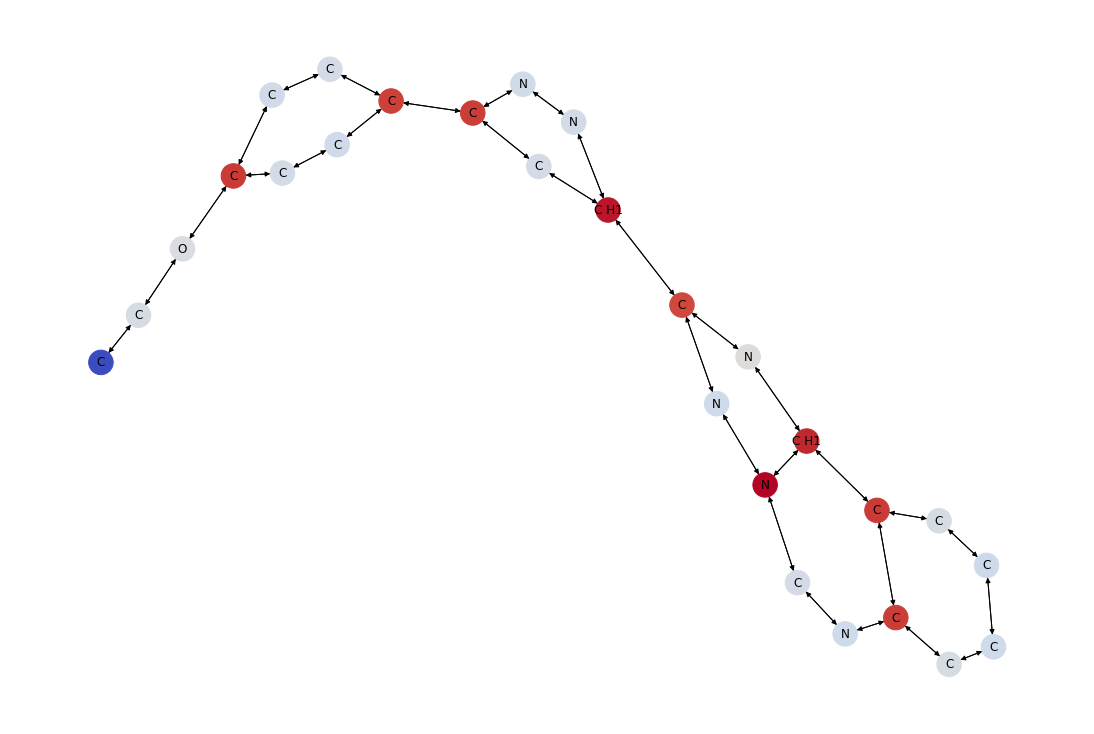


 Values of scores : 
 [1.0116842 2.0171666 2.0401125 2.9953816 1.9704721 2.002731  2.9801092
 2.9870892 1.9963843 3.0927935 2.9580011 1.9661868 3.1274238 1.998862
 1.9634293 2.9873629 2.0188458 1.9682169 1.9606302 2.0199196 2.9972844
 3.0557547 2.0843859 1.9898268 1.9729774 1.9647214 1.9923241] 

 _________ 


Expected solubility : 2.3868987560272217 .
Solubility predicted : 1.7135779857635498 . 

 --------------------------------------------------




Epoch 10:  10%|█         | 10/100 [02:16<20:23, 13.59s/it, lr=0.0007, test_MAE=0.556, time=13.5, train_MAE=0.457, train_loss=0.457, val_MAE=0.507, val_loss=0.507]


 @ Epoch 10 ------- 

 Showing 
 - 82th element out of 128 
 - in batch 42 out of 78



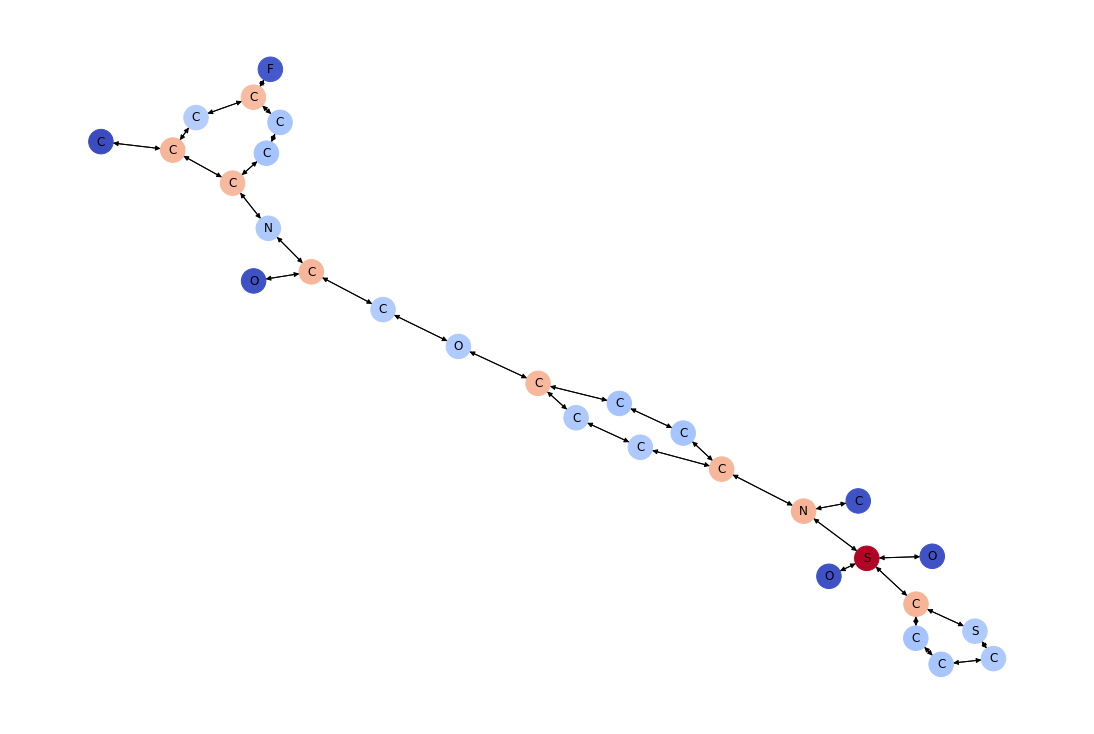


 Values of scores : 
 [0.9462703 2.9928539 2.0497837 2.9336987 1.0470169 1.9308246 1.9105331
 2.9452043 1.99863   2.9911404 0.9858267 2.0149536 2.0102787 2.971685
 1.9164312 1.9260064 2.9815068 3.0094097 1.0006596 3.9798222 0.9857314
 0.9857314 3.0043256 1.9099083 1.9399822 1.9902948 2.0069752 2.0000782
 1.9939613] 

 _________ 


Expected solubility : -0.5974013209342957 .
Solubility predicted : -0.9311528205871582 . 

 --------------------------------------------------




Epoch 20:  20%|██        | 20/100 [04:28<17:41, 13.27s/it, lr=0.0007, test_MAE=0.509, time=13.3, train_MAE=0.406, train_loss=0.406, val_MAE=0.447, val_loss=0.447]


 @ Epoch 20 ------- 

 Showing 
 - 31th element out of 128 
 - in batch 71 out of 78



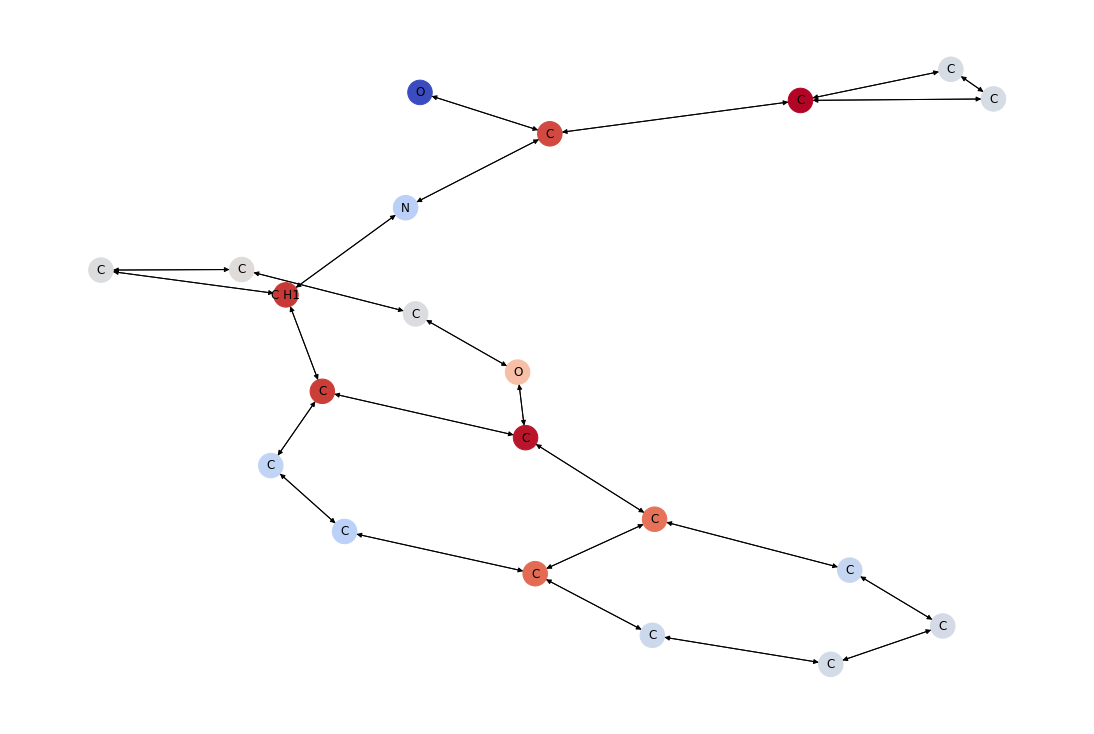


 Values of scores : 
 [0.91336215 2.9388943  1.7574849  3.0042503  2.0037026  2.0455167
 2.0006661  2.3368368  3.0877492  2.9845667  1.7974607  1.7688713
 2.8007755  1.8852538  1.9402201  1.945032   1.8440906  2.7656035
 3.1282897  1.9607201  1.9607201 ] 

 _________ 


Expected solubility : -2.534473419189453 .
Solubility predicted : -2.2931008338928223 . 

 --------------------------------------------------




Epoch 30:  30%|███       | 30/100 [06:42<15:33, 13.34s/it, lr=0.0007, test_MAE=0.442, time=13.1, train_MAE=0.369, train_loss=0.369, val_MAE=0.399, val_loss=0.399]


 @ Epoch 30 ------- 

 Showing 
 - 118th element out of 128 
 - in batch 33 out of 78



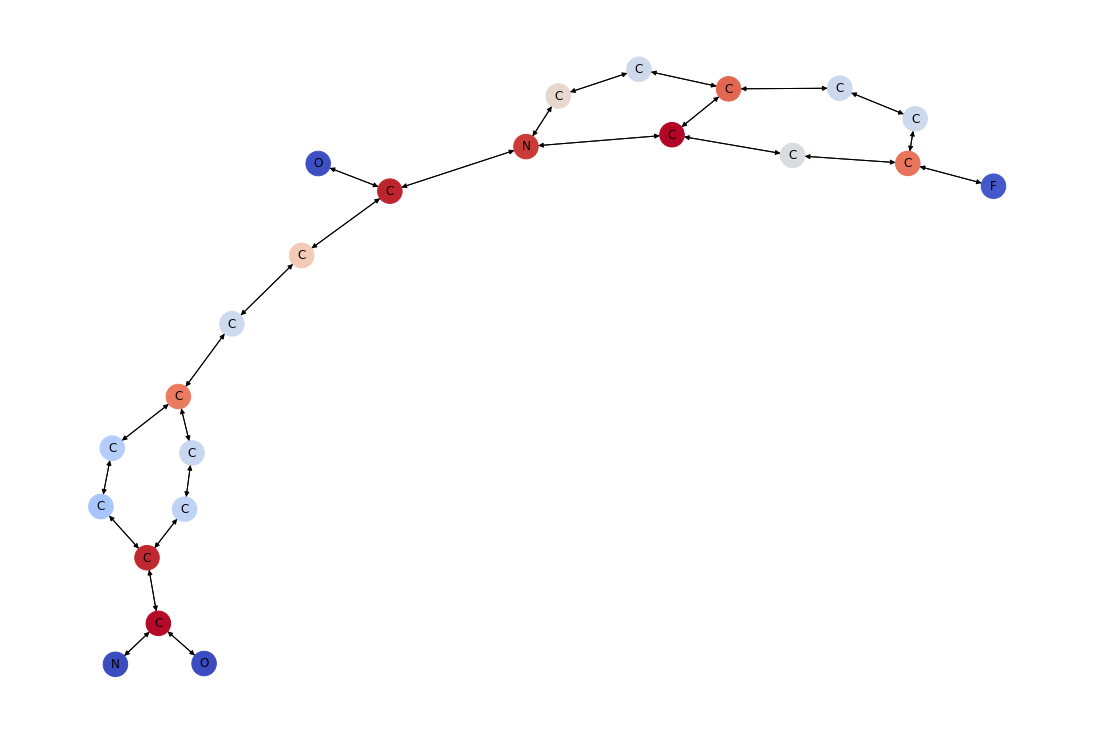


 Values of scores : 
 [0.8239613  3.0008938  0.8191454  2.9404216  1.6924189  1.7522401
 2.619742   1.7891299  2.1457593  2.9504404  0.83921444 2.8794956
 2.0004063  1.8005973  2.7141476  1.7798613  1.7908238  2.6476994
 0.8843156  1.887046   3.0153031  1.6255376  1.5376909 ] 

 _________ 


Expected solubility : -0.3433220684528351 .
Solubility predicted : -0.23159442842006683 . 

 --------------------------------------------------




Epoch 40:  40%|████      | 40/100 [08:57<13:27, 13.46s/it, lr=0.0007, test_MAE=0.42, time=13.1, train_MAE=0.344, train_loss=0.344, val_MAE=0.381, val_loss=0.381] 


 @ Epoch 40 ------- 

 Showing 
 - 38th element out of 128 
 - in batch 40 out of 78



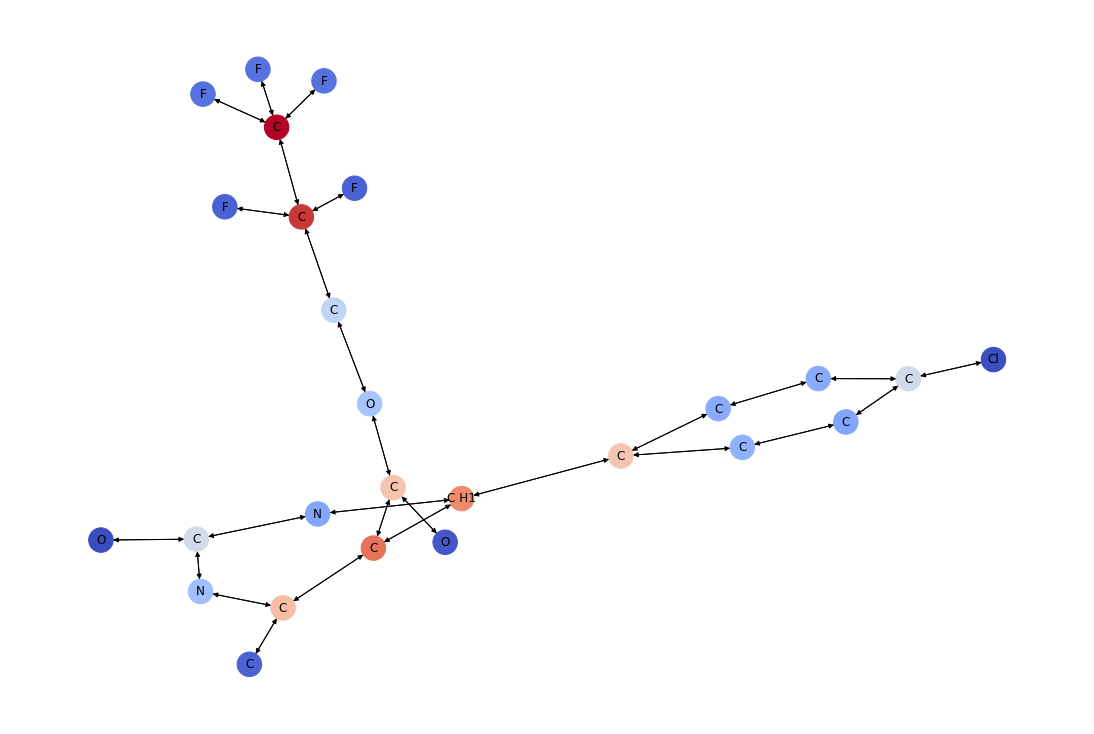


 Values of scores : 
 [0.9775929  2.9616818  3.6139672  2.8912134  0.87088835 1.8768656
 2.1464763  3.9667113  0.9437619  0.9437619  4.154417   1.0873343
 1.0873343  1.0873343  3.4377265  2.8758965  1.5851238  1.5787082
 2.315006   0.8025387  1.5244267  1.6655693  1.5329945  2.3292189
 0.78471553 1.8076696 ] 

 _________ 


Expected solubility : -0.46894651651382446 .
Solubility predicted : -0.20174676179885864 . 

 --------------------------------------------------




Epoch 47:  47%|████▋     | 47/100 [10:32<11:56, 13.51s/it, lr=0.0007, test_MAE=0.482, time=13.3, train_MAE=0.331, train_loss=0.331, val_MAE=0.462, val_loss=0.462]

Epoch    47: reducing learning rate of group 0 to 3.5000e-04.


Epoch 50:  50%|█████     | 50/100 [11:13<11:19, 13.59s/it, lr=0.00035, test_MAE=0.37, time=13.6, train_MAE=0.307, train_loss=0.307, val_MAE=0.34, val_loss=0.34]   


 @ Epoch 50 ------- 

 Showing 
 - 52th element out of 128 
 - in batch 23 out of 78



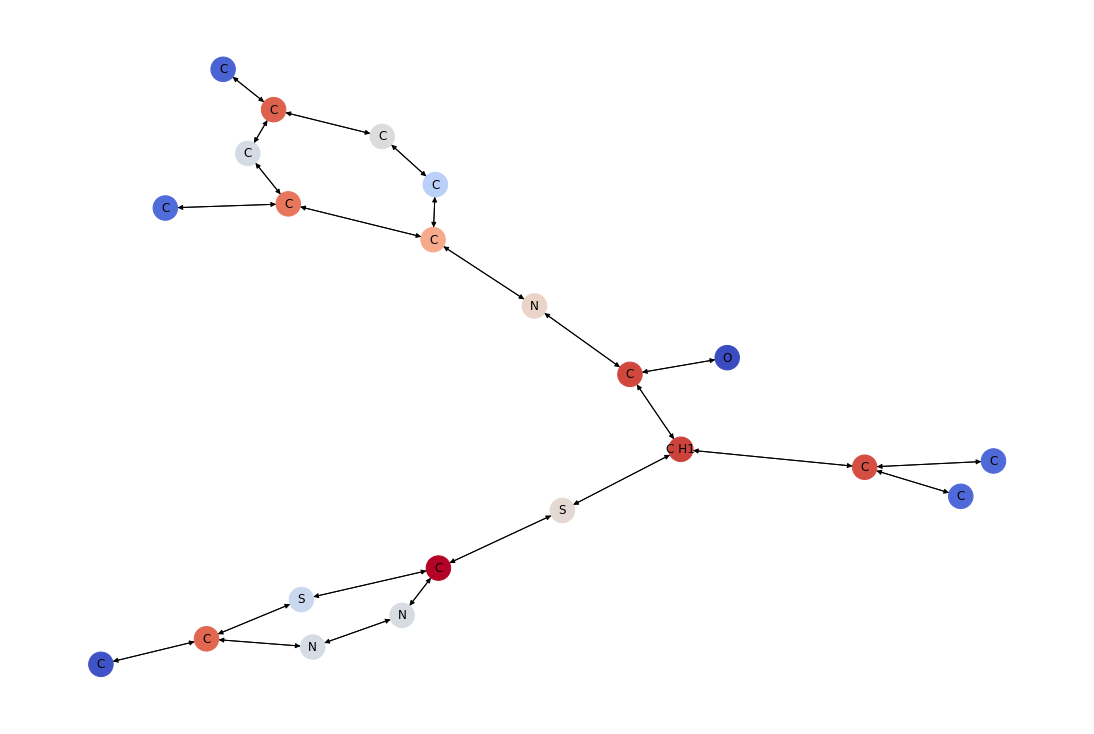


 Values of scores : 
 [0.9502441  2.8814113  2.0081558  1.7202477  2.4937835  2.130578
 2.9834502  0.8276865  3.004035   2.0739794  3.175736   1.9544474
 1.9377496  2.8495722  0.8696997  1.839293   2.9631124  0.9888796
 0.9888796  2.7789192  0.99612784 1.931576  ] 

 _________ 


Expected solubility : -0.40910521149635315 .
Solubility predicted : -0.21143487095832825 . 

 --------------------------------------------------




Epoch 60:  60%|██████    | 60/100 [13:26<08:51, 13.28s/it, lr=0.00035, test_MAE=0.364, time=13.3, train_MAE=0.284, train_loss=0.284, val_MAE=0.345, val_loss=0.345]


 @ Epoch 60 ------- 

 Showing 
 - 101th element out of 128 
 - in batch 29 out of 78



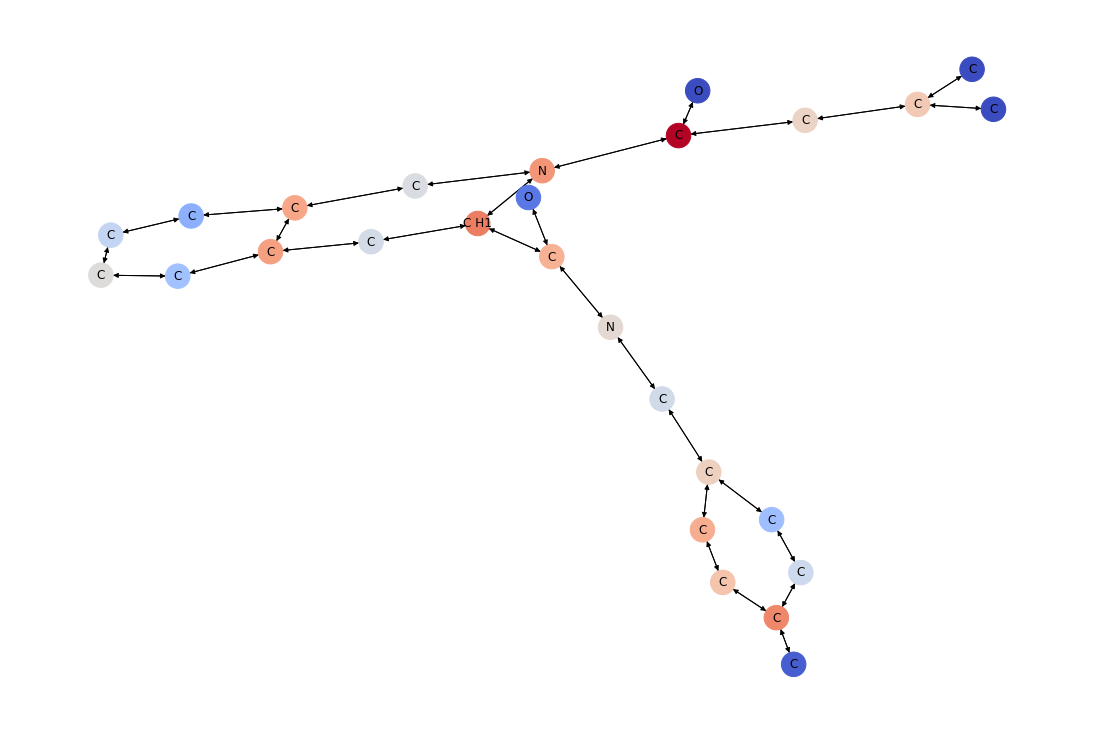


 Values of scores : 
 [0.9548652  2.922781   2.016848   1.6300087  2.3621988  2.0475597
 2.2331035  2.648035   1.1148618  2.9877524  2.0656984  2.7765846
 1.6567786  2.1751838  1.9307443  1.5072714  2.7303042  2.1227384
 2.8482275  3.4781127  0.8437818  2.3164039  2.4469666  0.85216725
 0.85216725 2.6830711  2.492128  ] 

 _________ 


Expected solubility : 1.6856913566589355 .
Solubility predicted : 1.6718274354934692 . 

 --------------------------------------------------




Epoch 70:  70%|███████   | 70/100 [15:39<06:39, 13.31s/it, lr=0.00035, test_MAE=0.33, time=13.3, train_MAE=0.263, train_loss=0.263, val_MAE=0.313, val_loss=0.313] 


 @ Epoch 70 ------- 

 Showing 
 - 97th element out of 128 
 - in batch 33 out of 78



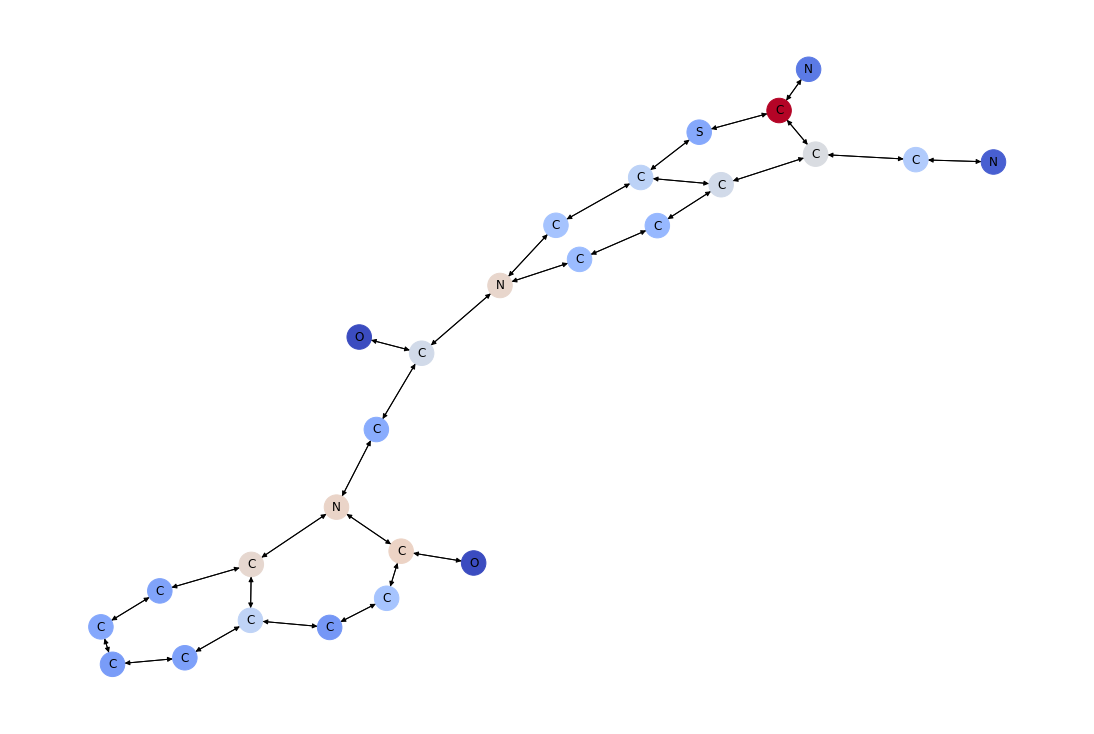


 Values of scores : 
 [0.97396475 2.2128024  2.7485092  4.819153   1.2324682  1.7157269
 2.3590493  2.6309674  1.9206004  1.9732522  2.9837382  2.6344464
 0.79752004 1.7665968  3.0309546  3.0717044  0.7979729  2.0971437
 1.5345883  2.390772   1.6250722  1.5762649  1.7008555  1.6583302
 2.9590392  2.0755818 ] 

 _________ 


Expected solubility : -0.09153369814157486 .
Solubility predicted : 0.08508200943470001 . 

 --------------------------------------------------




Epoch 80:  80%|████████  | 80/100 [17:52<04:23, 13.15s/it, lr=0.00035, test_MAE=0.327, time=13, train_MAE=0.237, train_loss=0.237, val_MAE=0.318, val_loss=0.318]  


 @ Epoch 80 ------- 

 Showing 
 - 84th element out of 128 
 - in batch 17 out of 78



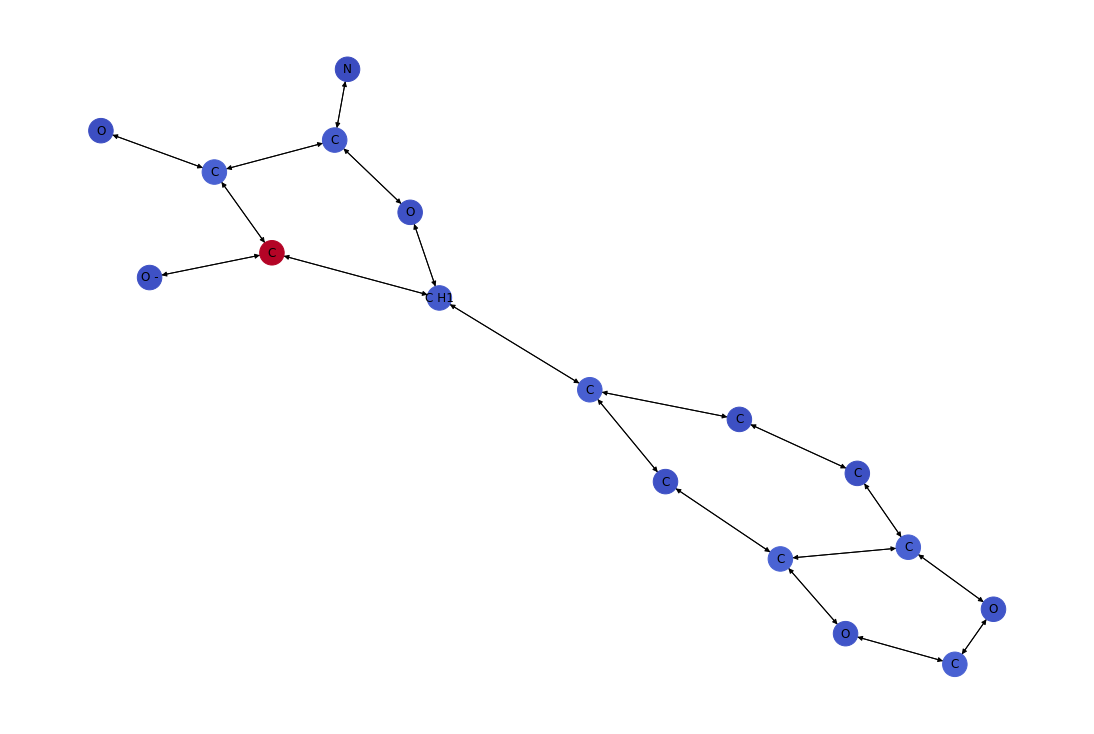


 Values of scores : 
 [ 1.0032214  2.895807   1.7162355  2.8518314  3.5009737  1.6587887
  1.5848328  3.7679818  2.135631   3.6865125  2.123114   3.9261217
  1.7562991 57.791885   1.6784662  3.8849583  1.2520077] 

 _________ 


Expected solubility : 1.6007623672485352 .
Solubility predicted : 1.1483193635940552 . 

 --------------------------------------------------




Epoch 84:  84%|████████▍ | 84/100 [18:45<03:30, 13.15s/it, lr=0.00035, test_MAE=0.331, time=13, train_MAE=0.236, train_loss=0.236, val_MAE=0.326, val_loss=0.326]  

Epoch    84: reducing learning rate of group 0 to 1.7500e-04.


Epoch 90:  90%|█████████ | 90/100 [20:04<02:12, 13.21s/it, lr=0.000175, test_MAE=0.294, time=13.1, train_MAE=0.215, train_loss=0.215, val_MAE=0.292, val_loss=0.292]


 @ Epoch 90 ------- 

 Showing 
 - 0th element out of 128 
 - in batch 57 out of 78



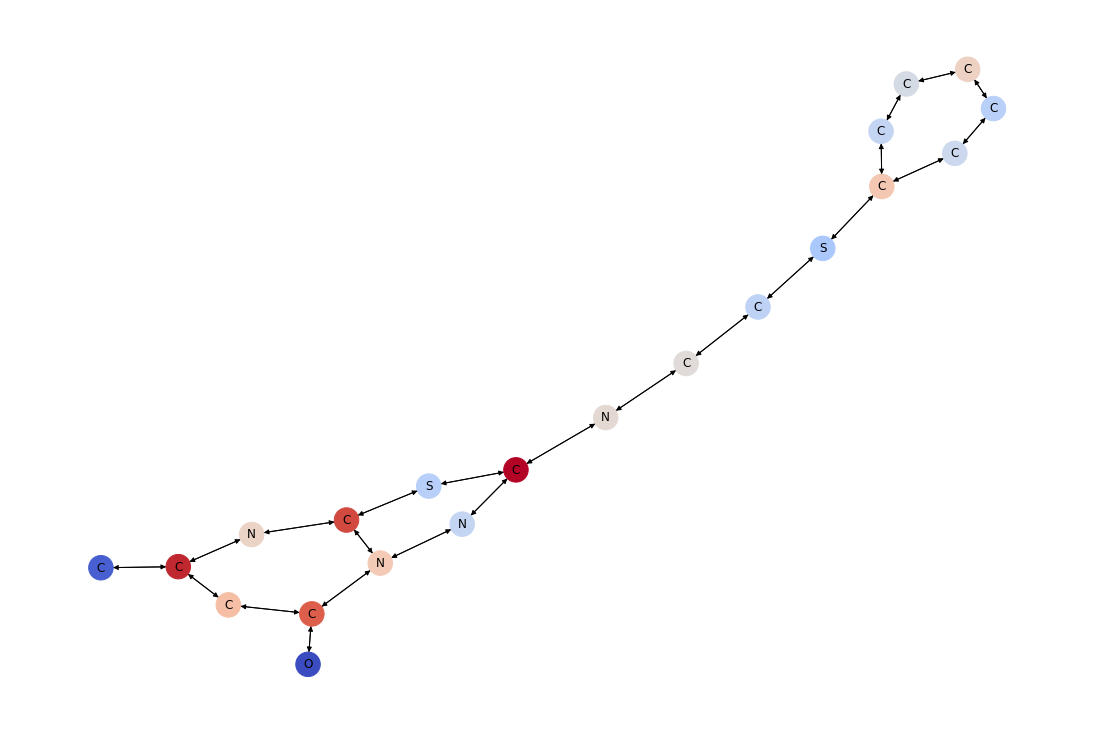


 Values of scores : 
 [0.77110124 3.6139016  2.6234372  3.3369007  0.6269734  2.4840245
 1.8925827  3.7104797  2.2599216  2.2062325  1.8419583  1.6661348
 2.5183072  1.9724002  1.792089   2.3960416  2.0788975  1.8930885
 1.7735803  3.4521828  2.3499732 ] 

 _________ 


Expected solubility : 1.059698462486267 .
Solubility predicted : 0.7427037358283997 . 

 --------------------------------------------------




Epoch 99: 100%|██████████| 100/100 [22:18<00:00, 13.38s/it, lr=0.000175, test_MAE=0.294, time=13.4, train_MAE=0.185, train_loss=0.185, val_MAE=0.292, val_loss=0.292]


Test MAE: 0.2945
Train MAE: 0.1532
Convergence Time (Epochs): 99.0000
TOTAL TIME TAKEN: 1360.2032s
AVG TIME PER EPOCH: 13.3430s


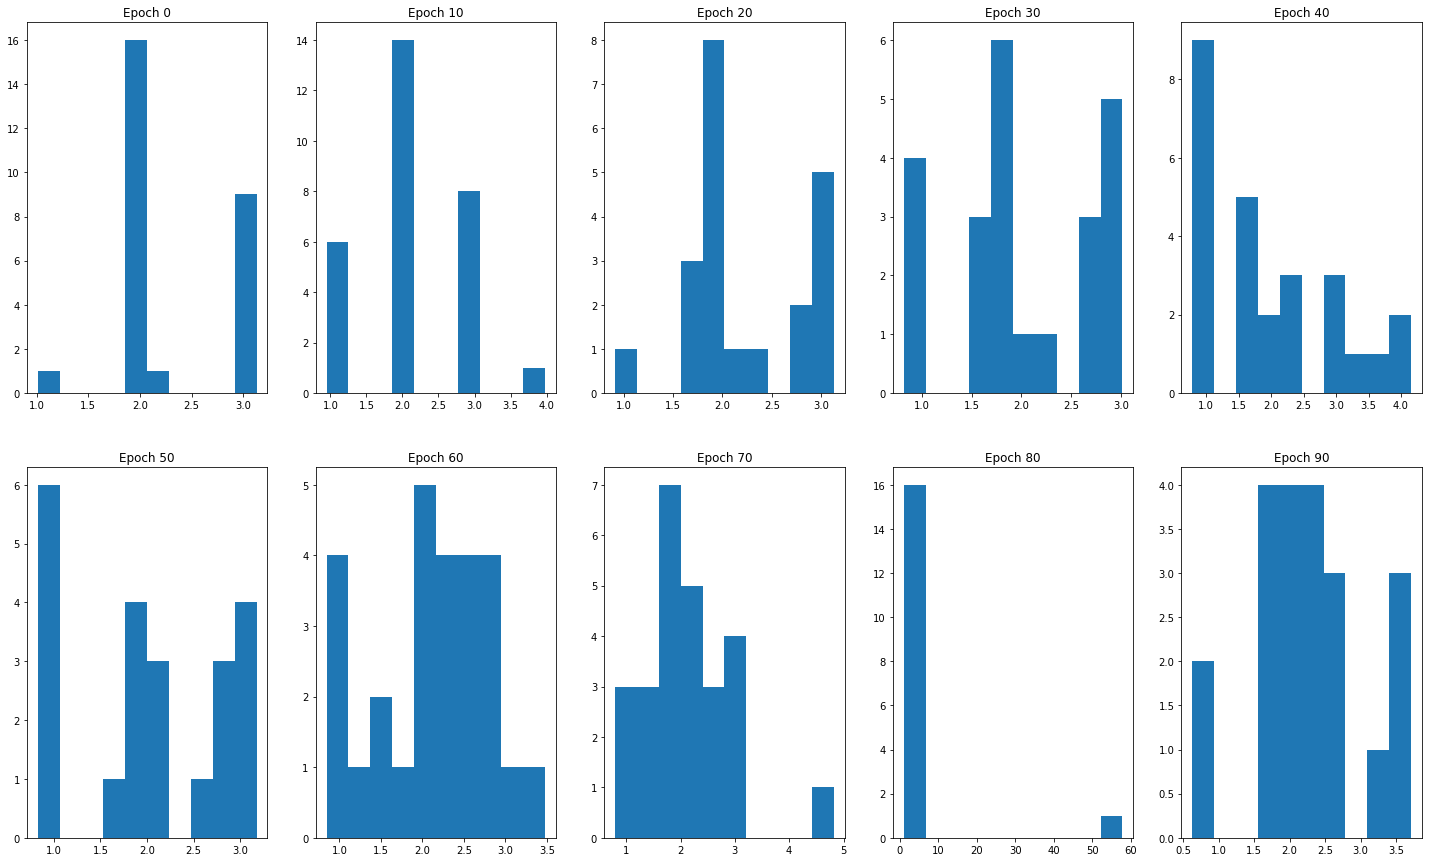

In [5]:
main()